# Interpretable Wordembedding Classifiers

## Introduction
Wordembeddings can be increadibly useful as features in classification models. Unlike bag-of-words approaches, wordembeddings can capture semantic relationships between words, and are fairly light compared embeddings from more complex models like ELMO and BERT.

Despite its usefulness and high performance, wordembeddings can often be difficult to use in classification tasks where it is vital that researchers are able to explain the data generating process, not just provide an accurate prediction. The embeddings are in and of themselves not interpretable, and therefore researchers often shy away from using them.

In this notebook I will present a simple as to how to how we can add interpretability to classifier models based on word embeddings, and a simple process for working our way back from predictions made by a classifier that takes wordembeddings as input to individual words or terms that the model seem to be using to discriminate your classes.

The approach can fairly simply be summarised as follows:

* Train a classifier that takes document level embeddings as input.
* Create a vocabulary matrix with ndividual word embeddings for all the words found in your corpus.
* Run the vocabulary matrix through the trained algorithm and pick out the individual words the algorithm feels the most certain belong to each class.

In the parts that follow I will demonstrate how this can be done by training a classifier to distinguish whether a newspaper headline came from a politics article or a sports article.


## Get News Headlines from The Guardian API

We firstly, need to get our data. The Guardian has a really good API for this purpose; so we can pull out all politics and sports articles from the Guardian between two arbitary points in time, say march and may 2018.

In [1]:
from GuardianAPI import Guardian_API
import pandas as pd

In [2]:
gapi = Guardian_API()

api_key: ········


In [3]:
sports_json = gapi.get_content({'section':'sport', 'from-date':'2018-03-1', 'to-date':'2018-05-30', 'code':'uk', 'page-size':50})

In [4]:
politics_json = gapi.get_content({'section':'politics', 'from-date':'2018-03-1', 'to-date':'2018-05-30', 'code':'uk', 'page-size':50})

In [5]:
df = pd.DataFrame(sports_json + politics_json)
df.sample(5)

,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,isHosted,pillarId,pillarName
401,sport/2018/may/06/justify-kentucky-derby-mende...,article,sport,Sport,2018-05-06T00:08:06Z,Justify reigns in the rain at Kentucky Derby a...,https://www.theguardian.com/sport/2018/may/06/...,https://content.guardianapis.com/sport/2018/ma...,False,pillar/sport,Sport
26,sport/2018/may/28/marco-trungelliti-road-trip-...,article,sport,Sport,2018-05-28T21:13:10Z,Marco Trungelliti makes 500-mile family road t...,https://www.theguardian.com/sport/2018/may/28/...,https://content.guardianapis.com/sport/2018/ma...,False,pillar/sport,Sport
2207,politics/2018/mar/11/labour-mps-should-not-app...,article,politics,Politics,2018-03-11T11:15:13Z,"Labour MPs should not appear on Russia Today, ...",https://www.theguardian.com/politics/2018/mar/...,https://content.guardianapis.com/politics/2018...,False,pillar/news,News
2205,politics/2018/mar/11/scottish-labour-conferenc...,article,politics,Politics,2018-03-11T15:43:53Z,Scottish Labour conference backs Corbyn on Brexit,https://www.theguardian.com/politics/2018/mar/...,https://content.guardianapis.com/politics/2018...,False,pillar/news,News
316,sport/2018/may/11/guildford-extend-record-run-...,article,sport,Sport,2018-05-11T18:28:33Z,Chess: Guildford extend their record unbeaten ...,https://www.theguardian.com/sport/2018/may/11/...,https://content.guardianapis.com/sport/2018/ma...,False,pillar/sport,Sport


## Pre-Trained Word Embeddings

We now need to get pre-trained word embeddings from gensims api and then create an embedding that represent each headline, by taking the average embedding of all the words used in each headline.

In [7]:
# Call in depenencies
import gensim.downloader as api
import re
import numpy as np
from nltk.corpus import stopwords

In [8]:
# Get glove embeddings
glove_vectors = api.load('glove-wiki-gigaword-300')

In [9]:
# Get a set of stopwords
StopWords = set(stopwords.open('english'))

In [10]:
def text_preprocess(text, word_vectors, StopWords):
    tmp_txt = text.lower() # lowercase all text
    tmp_txt = re.sub(r'\!', ' ! ', tmp_txt) # add a a space to each exclamation mark to ensure they get a token
    tmp_txt = re.sub(r'\?', ' ? ', tmp_txt) # add a a space to each question mark to ensure they get a token
    if stopwords:
        tokens = [w for w in tmp_txt.split() if w in word_vectors.vocab and w not in StopWords]
    else:
        tokens = [w for w in tmp_txt.split() if w in word_vectors.vocab]
    return tokens

In [11]:
def doc_vector(tokens, word_vectors):
    doc_vec = np.mean(np.array([word_vectors[word]
                                 for word in tokens]), axis = 0)
    return doc_vec

In [12]:
def concat_texts(corpus, word_vectors):
    out_matrix = np.empty((len(corpus), 300), float)
    for row,txt in enumerate(corpus):
        out_matrix[row] = doc_vector(txt, word_vectors)
    return out_matrix

In [13]:
headlines_processed = [text_preprocess(x, glove_vectors, StopWords) for x in df.webTitle]

In [14]:
headline_matrix = concat_texts(headlines_processed, glove_vectors)
headline_matrix.shape

(2293, 300)

## Split data into Training and Test Set

In [15]:
# Call dependency
from sklearn.model_selection import train_test_split

In [16]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(headline_matrix, 
                                                    df.sectionId, 
                                                    test_size=0.2, 
                                                    random_state=123)

In [17]:
print('Training Examples: ', X_train.shape, "\n"
      'Test Examples: ', X_test.shape)

Training Examples:  (1834, 300) 
Test Examples:  (459, 300)


## Get Vocabulary Matrix

We then need to get a matrix of individual words used in the model, that we can use to work our way back from a model prediction to a set of terms that explain those predictions. We can do this by tokenising all the data in our corpus and put these tokens into a set.

In [18]:
vocab = set()
for headline in df.webTitle:
    vocab.update([w.lower() for w in headline.split() if w.lower() in glove_vectors.vocab])
vocab = list(vocab)

In [19]:
vocab_matrix = np.array([glove_vectors[w] for w in vocab])

## Train Models

In [20]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

## Support Vector Machine

Support Vector Machines attempts to find a line or hyperplane that separates the datapoints from each class with the largest possible margin.

One way to understand what our model is picking up on is to calculate the distance of each of the words in our vocabulary to the decision plane. Words that are far from the decision plane are presumably more discriminative, and should therefore give us a clue as to what the model is picking up on. Similarly, words that are very close to the separating line should be words that are not discriminatory; meaning either general vocabulary or terms typically used in both domains.

We can get the distance of each word from the decision boundary by taking the decision function value we get from running the word through the trained algorithm divided by the l2 norm of the coefficient vector.

\begin{align}
dist & = \frac{f(x)}{\lVert w \rVert} \\
\end{align}

Below is a two-dimentional illustration of what we expect to see, but the intuition generalises to multiple dimensions

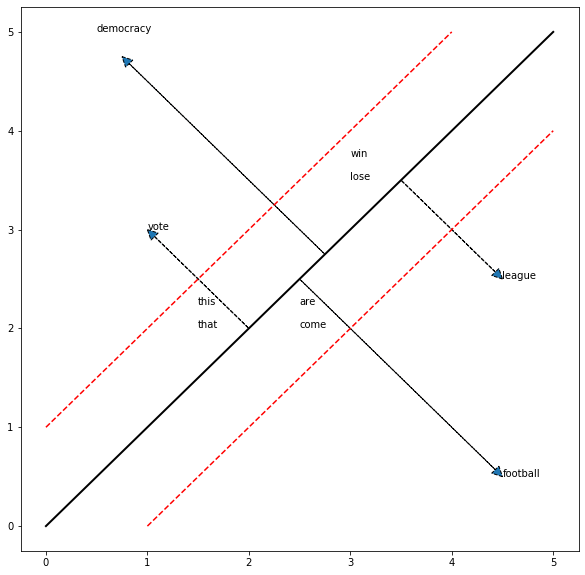

In [21]:
plt.figure(figsize=(10,10))
plt.plot([0, 5], [0, 5], 'k-', lw=2)
plt.plot([1, 5], [0, 4], '--', c='r')
plt.plot([0, 4], [1, 5], '--', c='r')

plt.arrow(2.5, 2.5, dx = 2, dy= -2, ls='--', length_includes_head = True, head_width=0.1, head_length=0.1)
plt.arrow(3.5, 3.5, dx = 1, dy= -1, ls='--', length_includes_head = True, head_width=0.1, head_length=0.1)
plt.arrow(2, 2, dx = -1, dy= 1, ls='--', length_includes_head = True, head_width=0.1, head_length=0.1)
plt.arrow(2.75, 2.75, dx = -2, dy= 2, ls='--', length_includes_head = True, head_width=0.1, head_length=0.1)

plt.annotate(s = 'democracy', xy = (0.5,5))
plt.annotate(s = 'vote', xy = (1,3))

plt.annotate(s = 'league', xy = (4.5,2.5))
plt.annotate(s = 'football', xy = (4.5,0.5))

plt.annotate(s = 'this\n\nthat', xy = (1.5,2))
plt.annotate(s = 'are\n\ncome', xy = (2.5,2))
plt.annotate(s = 'win\n\nlose', xy = (3,3.5))

plt.show()

## Train and Fit Model

In [22]:
from sklearn.svm import SVC

In [23]:
svm = SVC(kernel = 'linear', C = 1, class_weight='balanced')

In [24]:
svm.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Predict on unseen data

In [25]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    politics       0.91      0.97      0.94       158
       sport       0.98      0.95      0.97       301

    accuracy                           0.96       459
   macro avg       0.95      0.96      0.95       459
weighted avg       0.96      0.96      0.96       459



## Calculate distance from each word to the decision boundary

In [26]:
dist = svm.decision_function(vocab_matrix) / np.linalg.norm(svm.coef_)

In [27]:
distance_df = pd.DataFrame({'word':vocab, 'distance':dist})

## Sort Vocabulary Words by distance to the decision boundary

In [28]:
distance_df.sort_values('distance', ascending = False).head(10)

,word,distance
2582,sevens,2.561792
82,a-league,2.385136
2350,rugby,2.384202
1203,nrl,2.268408
1135,paralympic,2.252786
213,championship,2.213799
2177,cycling,2.199589
4190,tennis,2.159167
3435,tournament,2.144038
755,squad,2.125921


We can clearly see that the words that are the furthest from the decision boundary on the positive side are all sports related words like rugby, paralympic and tournament. This suggest that these words and words similar to them are particlarly important for the model to recognise a headline as a sports headline.

When looking at the words that are the furthest away from the decision boundary on the negative side, these are, as suspected political terms like minister, labour and parliament. Again this tells us that our model are focusing on terms that are similar to these when deciding whether to classify a headline as a politics headline.

In [29]:
distance_df.sort_values('distance', ascending = True).head(10)

,word,distance
803,minister,-2.222333
3697,labour,-2.092312
1654,parliament,-2.006268
2021,liberal,-1.884801
4103,tory,-1.868131
508,party,-1.847066
2063,conservatives,-1.814579
2584,chancellor,-1.798007
5290,tories,-1.710996
5216,conservative,-1.624608


We can look at words that are close to the decision boundary. Here we find as hypothesised a set of words that are either not associated with either politics or sports, like *when* or *talking*, or associated with both, like *defence* or *hamilton (both formula one driver and name of several politicians*.

In [30]:
distance_df.loc[distance_df.distance.between(-0.01, 0.01)].head(10)

,word,distance
18,launch,0.001324
117,appeal,-0.008476
145,vital,0.009059
195,bale,-0.002664
303,affected,-0.005008
329,mcnicholl,-0.009333
354,credentials,0.001708
473,barrel,-0.005074
518,anything,0.007034
571,aims,0.007861


# Logistic Regression

We can make a similar form of analysis using a logistic regression. However, rather than calculating the distance of all our vocabulary words from the decision boundary, we predict the class probability of each word.

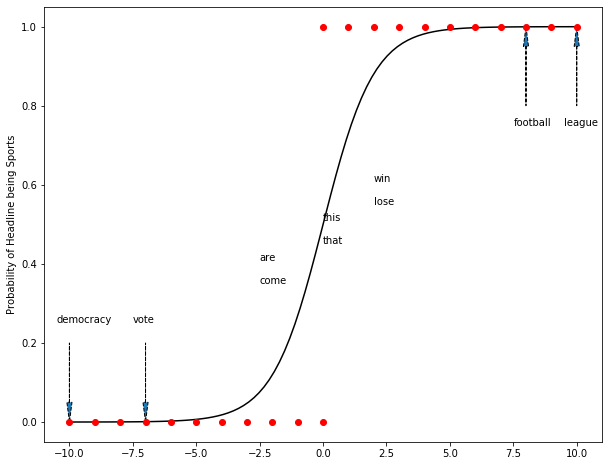

In [31]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
y=np.linspace(-10,10,100)

plt.figure(figsize=(10,8))
plt.plot(y,sigmoid(y),'k')
for i in range(-10, 1):
    plt.plot(i, 0, 'ro')
for i in range(0, 11):
    plt.plot(i, 1, 'ro')
plt.ylabel('Probability of Headline being Sports')
plt.arrow(-10, 0.2, dx = 0, dy= -0.2, ls='--', length_includes_head = True, head_width=0.2, head_length=0.05)
plt.arrow(-7, 0.2, dx = 0, dy= -0.2, ls='--', length_includes_head = True, head_width=0.2, head_length=0.05)
plt.arrow(10, 0.8, dx = 0, dy= 0.2, ls='--', length_includes_head = True, head_width=0.2, head_length=0.05)
plt.arrow(8, 0.8, dx = 0, dy= 0.2, ls='--', length_includes_head = True, head_width=0.2, head_length=0.05)

plt.annotate(s = 'democracy', xy = (-10.5,0.25))
plt.annotate(s = 'vote', xy = (-7.5,0.25))
plt.annotate(s = 'league', xy = (9.5,0.75))
plt.annotate(s = 'football', xy = (7.5,0.75))

plt.annotate(s = 'this\n\nthat', xy = (0, 0.45))
plt.annotate(s = 'are\n\ncome', xy = (-2.5, 0.35))
plt.annotate(s = 'win\n\nlose', xy = (2, 0.55))

plt.show()

## Train Model

In [32]:
# Dependency
from sklearn.linear_model import LogisticRegression

In [33]:
lr = LogisticRegression()

In [34]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    politics       0.91      0.97      0.94       158
       sport       0.98      0.95      0.97       301

    accuracy                           0.96       459
   macro avg       0.95      0.96      0.95       459
weighted avg       0.96      0.96      0.96       459



## Get probability score for each vocabulary word

In [36]:
prob_df = pd.DataFrame({'word':vocab, 'probability':lr.predict_proba(vocab_matrix)[:,0]})

In [37]:
prob_df.sort_values('probability', ascending = True).head(10)

,word,probability
2582,sevens,0.000000e+00
3435,tournament,2.220446e-16
213,championship,2.220446e-16
2350,rugby,8.881784e-16
82,a-league,1.998401e-15
4410,finals,1.998401e-15
3602,champions,3.530509e-14
1203,nrl,3.819167e-14
4190,tennis,4.796163e-14
755,squad,7.638334e-14


Again we are seeing near identical results to what we saw with the support vector machines. All terms with a low probability of being a politics headline are sports terms.

Of the words given a high probability for politics article, we see the same politics terms popping up as with the svm.

In [38]:
prob_df.sort_values('probability', ascending = False).head(10)

,word,probability
803,minister,1.0
3697,labour,1.0
1654,parliament,1.0
2021,liberal,1.0
508,party,1.0
2063,conservatives,1.0
4103,tory,1.0
1034,parliamentary,1.0
5290,tories,1.0
435,prime,1.0


# Random Forests

As you may have realised by now, this approach should work for any classifier that can output a probability score, be that a simple decision tree, a naive bayes or a deep neural network.

As a final demonstration, I will run the task through a Random Forest Classifier. 

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
rf = RandomForestClassifier(criterion = 'entropy', max_depth = 15)

In [41]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [42]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    politics       0.91      0.87      0.89       158
       sport       0.93      0.95      0.94       301

    accuracy                           0.92       459
   macro avg       0.92      0.91      0.91       459
weighted avg       0.92      0.92      0.92       459



In [43]:
tree_df = pd.DataFrame({'word':vocab ,'probability':rf.predict_proba(vocab_matrix)[:,0]})

In [44]:
tree_df.sort_values('probability', ascending = False).head(10)

,word,probability
3697,labour,0.93
2892,labor,0.92
1654,parliament,0.90
106,lawmakers,0.90
2028,political,0.90
5216,conservative,0.88
508,party,0.87
2021,liberal,0.87
2063,conservatives,0.86
634,reform,0.86


In [45]:
tree_df.sort_values('probability', ascending = True).head(10)

,word,probability
213,championship,0.07
2372,games,0.07
4049,matches,0.07
4410,finals,0.07
2020,scoring,0.09
3202,beating,0.09
2485,softball,0.12
2247,beat,0.12
3764,thrilling,0.12
3974,prix,0.13


## Conclusion

In this notebook I have proposed and demonstrated a simple approach to add interpretability to any classifier taking word embeddings as features. This simple approach allows you to sense check that what your classifier picks up is reasonable, and at least to some extent explain the data generating process.

All though this approach is not directly applicable to regression problems, you can do something fairly similar... but that is for another post.